# Deteksi Url Pishing

### A. Install dan Import Library

In [1]:
!pip install pandas numpy tldextract matplotlib seaborn scikit-learn scipy



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import tldextract
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack

### B. Load Dataset

In [3]:
# Load dataset with memory optimization
df = pd.read_csv('new_data_urls.csv', dtype={'url': 'string', 'status': 'int8'})
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [4]:
# Check dataset summary
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822010 entries, 0 to 822009
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     822010 non-null  string
 1   status  822010 non-null  int8  
dtypes: int8(1), string(1)
memory usage: 7.1 MB


### C. Preprocessing Awal

In [5]:
# Check for missing values
print("Missing Values:")
print(df.isna().sum())

Missing Values:
url       0
status    0
dtype: int64


In [6]:
# Drop missing values
df.dropna(inplace=True)

### D. Ekstraksi Fitur Kustom dari URL

In [7]:
# Extract domain-related features efficiently
def extract_features(url):
    extracted = tldextract.extract(url)
    domain = extracted.domain
    subdomain = extracted.subdomain
    
    return [
        len(url),  # URL length
        len(domain),  # Domain length
        sum(c.isdigit() for c in url),  # Number of digits
        sum(c in string.punctuation for c in url),  # Number of special characters
        any(word in url.lower() for word in ['secure', 'account', 'login', 'banking', 'confirm', 'verify', 'update']),  # Suspicious words
        1 if url.startswith('https') else 0,  # HTTPS presence
        subdomain.count('.')  # Number of subdomains
    ]

In [8]:
# Apply feature extraction efficiently
feature_names = ['url_length', 'domain_length', 'num_digits', 'num_special_chars', 'has_suspicious_word', 'is_https', 'num_subdomains']
X_numeric = np.array([extract_features(url) for url in df['url']], dtype=np.float32)

### E. Ekstraksi Fitur TF-IDF

In [9]:
# Convert URLs into TF-IDF features efficiently
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,3))
X_tfidf = vectorizer.fit_transform(df['url'])

### F. Gabungkan Fitur Numerik + TF-IDF

In [10]:
# Combine numeric features with TF-IDF features
X = hstack([X_numeric, X_tfidf], format='csr')
y = df['status']

### G. Stratified K-Fold Cross Validation

In [11]:
# Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train optimized RandomForest model
    clf = RandomForestClassifier(n_estimators=200, max_depth=50, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # Predictions
    y_pred = clf.predict(X_test)
    
    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

In [12]:
# Print data split information
print(f"Data split: {kf.get_n_splits()}-fold Stratified Cross Validation")
print(f"Total dataset: {len(df)}")
print(f"Train dataset size: {len(train_index)} ({len(train_index)/len(df)*100:.2f}%)")
print(f"Test dataset size: {len(test_index)} ({len(test_index)/len(df)*100:.2f}%)")

Data split: 5-fold Stratified Cross Validation
Total dataset: 822010
Train dataset size: 657608 (80.00%)
Test dataset size: 164402 (20.00%)


### H. Evaluasi Model

In [13]:
# Final accuracy after cross-validation
final_accuracy = np.mean(accuracies)
print("Final Accuracy:", final_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"✅ Final Accuracy: {final_accuracy*100:.2f}%\n")

Final Accuracy: 0.9156421454726826
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     78996
           1       0.88      0.97      0.92     85406

    accuracy                           0.91    164402
   macro avg       0.92      0.91      0.91    164402
weighted avg       0.92      0.91      0.91    164402

✅ Final Accuracy: 91.56%



### Menampilkan confusion matrix

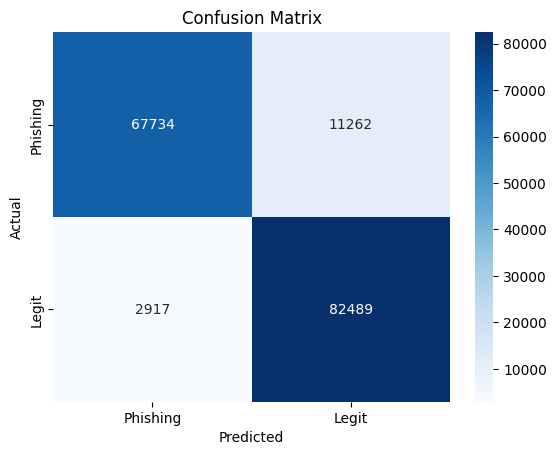

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Phishing', 'Legit'], yticklabels=['Phishing', 'Legit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### I. Testing Model

In [15]:
# Testing model with a sample URL
def predict_url(url):
    features = np.array([extract_features(url)], dtype=np.float32)
    tfidf_features = vectorizer.transform([url])
    X_sample = hstack([features, tfidf_features], format='csr')
    prediction = clf.predict(X_sample)
    return "Legitimate url" if prediction[0] == 1 else "Possible Phishing url"

In [16]:
# Testing model with a sample URL
sample_url = "https://www.microsoft.com/id-id"
result = predict_url(sample_url)
print(f"The URL '{sample_url}' is classified as: {result}")

sample_url = "https://upgrade-0947ameri-09.weebly.com/"
result = predict_url(sample_url)
print(f"The URL '{sample_url}' is classified as: {result}")

The URL 'https://www.microsoft.com/id-id' is classified as: Legitimate url
The URL 'https://upgrade-0947ameri-09.weebly.com/' is classified as: Possible Phishing url
